In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error
import json
import requests

# Load Data

In [2]:
import os
print(os.getcwd())
print(os.listdir())

/content
['.config', 'department-v2.csv', 'wandb', 'linkedin-cvs-not-annotated.json', 'seniority-v2.csv', 'linkedin-cvs-annotated.json', 'dep_distilbert_rule', 'dep_distilbert', 'sample_data']


In [3]:
df_department = pd.read_csv('department-v2.csv')
df_department['text'] = df_department['text'].str.lower()

display(df_department)
display(df_department.isna().sum())
pd.unique(df_department['label'])

,text,label
0,adjoint directeur communication,Marketing
1,advisor strategy and projects,Project Management
2,beratung & projekte,Project Management
3,beratung & projektmanagement,Project Management
4,beratung und projektmanagement kommunale partner,Project Management
...,...,...
10140,vp sales d.a.ch.,Sales
10141,vp sales dach,Sales
10142,vp sales development & strategy,Sales
10143,vp sales germany,Sales


,0
text,0
label,0


array(['Marketing', 'Project Management', 'Administrative',
       'Business Development', 'Consulting', 'Human Resources',
       'Information Technology', 'Other', 'Purchasing', 'Sales',
       'Customer Support'], dtype=object)

In [4]:
df_seniority = pd.read_csv('seniority-v2.csv')
df_seniority['text'] = df_seniority['text'].str.lower()

display(df_seniority, df_seniority.isna().sum())
pd.unique(df_seniority['label'])

,text,label
0,analyst,Junior
1,analyste financier,Junior
2,anwendungstechnischer mitarbeiter,Junior
3,application engineer,Senior
4,applications engineer,Senior
...,...,...
9423,vp sales d.a.ch.,Management
9424,vp sales dach,Management
9425,vp sales development & strategy,Management
9426,vp sales germany,Management


,0
text,0
label,0


array(['Junior', 'Senior', 'Lead', 'Management', 'Director'], dtype=object)

In [5]:
df_seniority["label"].value_counts()

,count
label,
Senior,3733
Lead,3546
Director,984
Management,756
Junior,409


In [6]:
df_department["label"].value_counts()

,count
label,
Marketing,4295
Sales,3328
Information Technology,1305
Business Development,620
Project Management,201
Consulting,167
Administrative,83
Other,42
Purchasing,40


In [7]:
file_path_annotated = 'linkedin-cvs-annotated.json'
file_path_tobepredict = 'linkedin-cvs-not-annotated.json'

def read_json_file(file_path):
  with open(file_path, 'r') as file:
      jason_data = json.load(file)

  flat_data = []
  for item in jason_data:
      for subitem in item:
          flat_data.append(subitem)

  df = pd.DataFrame(flat_data)
  return df

df = read_json_file(file_path_annotated)
df_predict = read_json_file(file_path_tobepredict)

display(df,df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638 entries, 0 to 2637
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   organization  2638 non-null   object
 1   linkedin      2638 non-null   object
 2   position      2638 non-null   object
 3   startDate     2520 non-null   object
 4   endDate       1897 non-null   object
 5   status        2638 non-null   object
 6   department    2638 non-null   object
 7   seniority     2638 non-null   object
dtypes: object(8)
memory usage: 165.0+ KB


/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,organization,linkedin,position,startDate,endDate,status,department,seniority
0,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Prokurist,2019-08,None,ACTIVE,Other,Management
1,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,CFO,2019-07,None,ACTIVE,Other,Management
2,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Betriebswirtin,2019-07,None,ACTIVE,Other,Professional
3,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Prokuristin,2019-07,None,ACTIVE,Other,Management
4,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,CFO,2019-07,None,ACTIVE,Other,Management
...,...,...,...,...,...,...,...,...
2633,Bistum,,Justitiar,2014-03,None,ACTIVE,Other,Professional
2634,FORESTA Management,,Geschäftsführer,2010-01,None,ACTIVE,Other,Management
2635,Malteser Hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,Präsidium,1999,None,ACTIVE,Other,Management
2636,Spies & Brunner RAe,,Rechtsanwalt,1995-01,None,ACTIVE,Other,Professional


None

In [8]:
df[['position', 'status', 'organization']] = df[['position', 'status', 'organization']].apply(lambda x: x.str.lower())

df

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,organization,linkedin,position,startDate,endDate,status,department,seniority
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
...,...,...,...,...,...,...,...,...
2633,bistum,,justitiar,2014-03,None,active,Other,Professional
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management
2636,spies & brunner rae,,rechtsanwalt,1995-01,None,active,Other,Professional


In [9]:
df['status'].value_counts()

,count
status,
inactive,1897
active,623
unknown,118


In [10]:
df_linkedin = df.copy()
df_linkedin = df_linkedin[df_linkedin['status'] == 'active']

df_linkedin

,organization,linkedin,position,startDate,endDate,status,department,seniority
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
...,...,...,...,...,...,...,...,...
2632,malteserorden,,kanzler der deutschen assoziation,2015-01,None,active,Other,Management
2633,bistum,,justitiar,2014-03,None,active,Other,Professional
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management


In [11]:
display(df_predict,df_predict.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   organization  1886 non-null   object
 1   linkedin      1886 non-null   object
 2   position      1886 non-null   object
 3   startDate     1828 non-null   object
 4   endDate       1409 non-null   object
 5   status        1886 non-null   object
dtypes: object(6)
memory usage: 88.5+ KB


/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,organization,linkedin,position,startDate,endDate,status
0,"Keeping The Books, Bookkeeping",,Bookkeeper,2023-03,None,ACTIVE
1,Playful Paws,,Co-Owner,2018-11,None,ACTIVE
2,S&R services,,Logistics Officer,2019-09,2024-04,INACTIVE
3,ABC Supply Co. Inc.,https://www.linkedin.com/company/abc-supply,Truck driver/ laborer,2019-03,2019-09,INACTIVE
4,MB Railways,,Fuel Driver,2018-03,2019-03,INACTIVE
...,...,...,...,...,...,...
1881,Euler Hermes Deutschland,https://www.linkedin.com/company/allianz-trade...,Juristischer Berater,1996-03,None,ACTIVE
1882,Folkwang Universität der Künste,,"Leitung Personal, Finanzen, Einkauf, IT | Folk...",2015-07,None,ACTIVE
1883,Landesspracheninstitut in der Ruhr-Universität...,,Verwaltungsleitung Landesspracheninstitut in d...,2005-10,2015-06,INACTIVE
1884,Folkwang Universität der Künste,,"Leitung Gebäudemanagement, Einkauf und Control...",2004-03,2005-09,INACTIVE


None

In [12]:
df_predict[['position', 'status', 'organization']] = df_predict[['position', 'status', 'organization']].apply(lambda x: x.str.lower())

df_predict

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,organization,linkedin,position,startDate,endDate,status
0,"keeping the books, bookkeeping",,bookkeeper,2023-03,None,active
1,playful paws,,co-owner,2018-11,None,active
2,s&r services,,logistics officer,2019-09,2024-04,inactive
3,abc supply co. inc.,https://www.linkedin.com/company/abc-supply,truck driver/ laborer,2019-03,2019-09,inactive
4,mb railways,,fuel driver,2018-03,2019-03,inactive
...,...,...,...,...,...,...
1881,euler hermes deutschland,https://www.linkedin.com/company/allianz-trade...,juristischer berater,1996-03,None,active
1882,folkwang universität der künste,,"leitung personal, finanzen, einkauf, it | folk...",2015-07,None,active
1883,landesspracheninstitut in der ruhr-universität...,,verwaltungsleitung landesspracheninstitut in d...,2005-10,2015-06,inactive
1884,folkwang universität der künste,,"leitung gebäudemanagement, einkauf und control...",2004-03,2005-09,inactive


In [13]:
df_predict['status'].value_counts()

,count
status,
inactive,1409
active,419
unknown,58


In [14]:
df_pred_linkedin = df_predict.copy()

df_pred_linkedin

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,organization,linkedin,position,startDate,endDate,status
0,"keeping the books, bookkeeping",,bookkeeper,2023-03,None,active
1,playful paws,,co-owner,2018-11,None,active
2,s&r services,,logistics officer,2019-09,2024-04,inactive
3,abc supply co. inc.,https://www.linkedin.com/company/abc-supply,truck driver/ laborer,2019-03,2019-09,inactive
4,mb railways,,fuel driver,2018-03,2019-03,inactive
...,...,...,...,...,...,...
1881,euler hermes deutschland,https://www.linkedin.com/company/allianz-trade...,juristischer berater,1996-03,None,active
1882,folkwang universität der künste,,"leitung personal, finanzen, einkauf, it | folk...",2015-07,None,active
1883,landesspracheninstitut in der ruhr-universität...,,verwaltungsleitung landesspracheninstitut in d...,2005-10,2015-06,inactive
1884,folkwang universität der künste,,"leitung gebäudemanagement, einkauf und control...",2004-03,2005-09,inactive


# 1. Rule-based matching

Pure text matching.

Using csv of department and seniority data as reference to predic JSON linkedin data

In [15]:
department_list = [(row['text'], row['label']) for index, row in df_department.iterrows()]
seniority_list = [(row['text'], row['label']) for index, row in df_seniority.iterrows()]

df_linkedin_textmatch = df_linkedin.copy()

X_base = df_linkedin_textmatch['position']
y_base_dept = df_linkedin_textmatch['department']
y_base_seni = df_linkedin_textmatch['seniority']

def pred_dept_text(X_base):
    for text, label in department_list:
        if text in X_base:
            return label
    return 'Other'

def pred_sen_text(X_base):
    for text, label in seniority_list:
        if text in X_base:
            return label
    return 'Other'

df_linkedin_textmatch['pred_dept_text'] = X_base.apply(pred_dept_text)
df_linkedin_textmatch['pred_sen_text'] = X_base.apply(pred_sen_text)

accuracy_dept_text = accuracy_score(y_base_dept, df_linkedin_textmatch['pred_dept_text'])
accuracy_seni_text = accuracy_score(y_base_seni, df_linkedin_textmatch['pred_sen_text'])

print(f'Department Prediction Accuracy: {accuracy_dept_text}')
print(f'Seniority Prediction Accuracy: {accuracy_seni_text}')

Department Prediction Accuracy: 0.622792937399679
Seniority Prediction Accuracy: 0.35313001605136435


Manual splitting original text into a set of words.

The matching accuracy improved little.

In [16]:
df_linkedin_tokenmatch = df_linkedin.copy()

X_base2 = df_linkedin_tokenmatch['position']
y_base_dept2 = df_linkedin_tokenmatch['department']
y_base_seni2 = df_linkedin_tokenmatch['seniority']

department_keywords = [
    (set(row['text'].split()), row['label'])
    for index, row in df_department.iterrows()
]

seniority_keywords = [
    (set(row['text'].split()), row['label'])
    for index, row in df_seniority.iterrows()
]

def pred_dept_token(X_base2):
    position_tokens = set(X_base2.split())
    for keyword, label in department_keywords:
        if keyword.issubset(position_tokens):
            return label
    return 'Other'

def pred_sen_token(X_base2):
    position_tokens = set(X_base2.split())
    for keyword, label in seniority_keywords:
        if keyword.issubset(position_tokens):
            return label
    return 'Other'

df_linkedin_tokenmatch['pred_dept_token'] = X_base2.apply(pred_dept_token)
df_linkedin_tokenmatch['pred_sen_token'] = X_base2.apply(pred_sen_token)

accuracy_dept_token = accuracy_score(y_base_dept2, df_linkedin_tokenmatch['pred_dept_token'])
accuracy_seni_token = accuracy_score(y_base_seni2, df_linkedin_tokenmatch['pred_sen_token'])

print(f'Department Prediction Accuracy: {accuracy_dept_token}')
print(f'Seniority Prediction Accuracy: {accuracy_seni_token}')

Department Prediction Accuracy: 0.6837881219903692
Seniority Prediction Accuracy: 0.33386837881219905


# 2. Embedding-based labelling

In [17]:
from sentence_transformers import SentenceTransformer, util
import torch

In [18]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [19]:
df_linkedin_emb = df_linkedin.copy()

# Get labels from csv
dept_lables = df_department['label'].unique().tolist()
seni_lables = df_seniority['label'].unique().tolist()

dept_embeddings = model.encode(dept_lables, convert_to_tensor=True)
seni_embeddings = model.encode(seni_lables, convert_to_tensor=True)

X_emb = df_linkedin_emb['position']

# Compare position text embeddings to lable embeddeints
def zero_shot_classification (X_emb, label_names, label_embeddings):
  position_embedding = model.encode(X_emb, convert_to_tensor=True)
  cosine_scores = util.cos_sim(position_embedding, label_embeddings)
  match_idx = torch.argmax(cosine_scores).item()
  return label_names[match_idx]

pred_dept_emb = [zero_shot_classification(x, dept_lables, dept_embeddings) for x in X_emb]

pred_seni_emb = [zero_shot_classification(x, seni_lables, seni_embeddings) for x in X_emb]

df_linkedin_emb['pred_dept_emb'] = pred_dept_emb
df_linkedin_emb['pred_seni_emb'] = pred_seni_emb

df_linkedin_emb

,organization,linkedin,position,startDate,endDate,status,department,seniority,pred_dept_emb,pred_seni_emb
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management,Administrative,Director
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management,Administrative,Management
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional,Other,Lead
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management,Administrative,Director
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management,Administrative,Management
...,...,...,...,...,...,...,...,...,...,...
2632,malteserorden,,kanzler der deutschen assoziation,2015-01,None,active,Other,Management,Administrative,Management
2633,bistum,,justitiar,2014-03,None,active,Other,Professional,Administrative,Lead
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management,Administrative,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management,Administrative,Lead


In [20]:
accuracy_dept = accuracy_score(df_linkedin_emb['department'], df_linkedin_emb['pred_dept_emb'])
accuracy_seni = accuracy_score(df_linkedin_emb['seniority'], df_linkedin_emb['pred_seni_emb'])

print(f'Embedding Department Prediction Accuracy: {accuracy_dept}')
print(f'Embedding Seniority Prediction Accuracy: {accuracy_seni}')

Embedding Department Prediction Accuracy: 0.21187800963081863
Embedding Seniority Prediction Accuracy: 0.30818619582664525


# 3. Fine-tune initial

In [21]:
# data split
X = df_department["text"]
y = df_department["label"]

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    )
print("Department train/test:", len(X_train_base), len(X_test_base))


Department train/test: 8116 2029


In [22]:
!pip install transformers torch accelerate

In [23]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset
import torch

# tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")

class TextClsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [24]:
# labels -> ids (train-only)
labels_dep = pd.Index(sorted(df_department["label"].unique()))
label2id_dep = {lab: i for i, lab in enumerate(labels_dep)}
id2label_dep = {i: lab for lab, i in label2id_dep.items()}

y_train_base_id = pd.Series(y_train_base).map(label2id_dep)
y_test_base_id  = pd.Series(y_test_base).map(label2id_dep)

train_ds_dep = TextClsDataset(X_train_base, y_train_base_id, tokenizer)
test_ds_dep  = TextClsDataset(X_test_base, y_test_base_id, tokenizer)

print("Train dataset size:", len(train_ds_dep))
print("Test dataset size:", len(test_ds_dep))
print("Num classes:", len(labels_dep))

Train dataset size: 8116
Test dataset size: 2029
Num classes: 11


In [25]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
model_dep = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=len(labels_dep),
    id2label={i: lab for i, lab in enumerate(labels_dep)},
    label2id={lab: i for i, lab in enumerate(labels_dep)})

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted")}

In [27]:
training_args = TrainingArguments(
    output_dir="./dep_distilbert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=6,
    weight_decay=0.05,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro"
)

In [28]:
trainer_dep = Trainer(
    model=model_dep,
    args=training_args,
    train_dataset=train_ds_dep,
    eval_dataset=test_ds_dep,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)

trainer_dep.train()
trainer_dep.evaluate()

/tmp/ipython-input-3171256691.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_dep = Trainer(
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"
wandb: Using W&B in offline mode.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.080800,0.102133,0.980779,0.683990,0.975963
2,0.037800,0.054641,0.992607,0.959602,0.992544
3,0.027300,0.050399,0.992607,0.967878,0.992590
4,0.011500,0.048623,0.993593,0.974362,0.993583
5,0.025900,0.047894,0.993100,0.972832,0.993090
6,0.009300,0.048981,0.993100,0.972832,0.993090


{'eval_loss': 0.04862338677048683,
 'eval_accuracy': 0.9935929029078364,
 'eval_f1_macro': 0.974362451948883,
 'eval_f1_weighted': 0.9935827739817014,
 'eval_runtime': 6.9122,
 'eval_samples_per_second': 293.54,
 'eval_steps_per_second': 9.259,
 'epoch': 6.0}

In [29]:
# JUST A TEST
pred_logits = trainer_dep.predict(test_ds_dep).predictions
pred_ids = pred_logits.argmax(axis=1)

pred_labels = pd.Series(pred_ids).map(id2label_dep)
pred_labels.value_counts().head(20)

,count
Marketing,855
Sales,660
Information Technology,266
Business Development,138
Project Management,33
Consulting,32
Other,12
Administrative,11
Customer Support,10
Purchasing,8


In [30]:
from sklearn.metrics import classification_report

true_labels = y_test_base_id.map(id2label_dep)
print(classification_report(true_labels, pred_labels, digits=4))

                        precision    recall  f1-score   support

        Administrative     1.0000    1.0000    1.0000        11
  Business Development     1.0000    0.9857    0.9928       140
            Consulting     1.0000    0.9697    0.9846        33
      Customer Support     1.0000    1.0000    1.0000        10
       Human Resources     1.0000    0.8000    0.8889         5
Information Technology     0.9812    0.9886    0.9849       264
             Marketing     0.9965    0.9977    0.9971       854
                 Other     1.0000    1.0000    1.0000        12
    Project Management     0.9394    0.9394    0.9394        33
            Purchasing     0.8750    1.0000    0.9333         7
                 Sales     0.9970    0.9970    0.9970       660

              accuracy                         0.9936      2029
             macro avg     0.9808    0.9707    0.9744      2029
          weighted avg     0.9937    0.9936    0.9936      2029



Json Test

In [31]:
df_linkedin

,organization,linkedin,position,startDate,endDate,status,department,seniority
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
...,...,...,...,...,...,...,...,...
2632,malteserorden,,kanzler der deutschen assoziation,2015-01,None,active,Other,Management
2633,bistum,,justitiar,2014-03,None,active,Other,Professional
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management


In [32]:
df_test = df_linkedin.copy()
df_test = df_test[df_test["status"] == "active"].copy()

X_json_dep = df_test["position"].fillna("").astype(str)
y_json_dep_raw = df_test["department"].fillna("").astype(str)

# unknown to Other
OTHER_LABEL = "Other"
if OTHER_LABEL not in label2id_dep:
    raise ValueError(f'"{OTHER_LABEL}" not in training label2id_dep. Check your training labels.')

y_json_dep = y_json_dep_raw.where(y_json_dep_raw.isin(label2id_dep.keys()), OTHER_LABEL)
y_json_dep_id = y_json_dep.map(label2id_dep)

In [33]:
(y_json_dep_raw != y_json_dep).value_counts()

,count
department,
False,623


In [34]:
json_test_ds_dep = TextClsDataset(X_json_dep, y_json_dep_id, tokenizer)

pred_logits_json = trainer_dep.predict(json_test_ds_dep).predictions
pred_ids_json = pred_logits_json.argmax(axis=1)

pred_labels_json = pd.Series(pred_ids_json).map(id2label_dep)
true_labels_json = y_json_dep_id.map(id2label_dep)

from sklearn.metrics import classification_report, accuracy_score, f1_score

print(classification_report(true_labels_json, pred_labels_json, digits=4, zero_division=0))

json_out_metrics = {
    "n_samples": len(df_test),
    "n_unknown_mapped_to_other": int((y_json_dep_raw != y_json_dep).sum()),
    "accuracy": accuracy_score(true_labels_json, pred_labels_json),
    "f1_macro": f1_score(true_labels_json, pred_labels_json, average="macro"),
    "f1_weighted": f1_score(true_labels_json, pred_labels_json, average="weighted")}
json_out_metrics

                        precision    recall  f1-score   support

        Administrative     0.5000    0.0714    0.1250        14
  Business Development     0.3750    0.3000    0.3333        20
            Consulting     0.6562    0.5385    0.5915        39
      Customer Support     1.0000    0.1667    0.2857         6
       Human Resources     0.0652    0.7500    0.1200        16
Information Technology     0.1949    0.7419    0.3087        62
             Marketing     0.5294    0.4091    0.4615        22
                 Other     0.5000    0.0029    0.0058       344
    Project Management     0.4167    0.7692    0.5405        39
            Purchasing     0.3000    0.4000    0.3429        15
                 Sales     0.7317    0.6522    0.6897        46

              accuracy                         0.2616       623
             macro avg     0.4790    0.4365    0.3459       623
          weighted avg     0.4772    0.2616    0.1996       623



{'n_samples': 623,
 'n_unknown_mapped_to_other': 0,
 'accuracy': 0.26163723916532905,
 'f1_macro': 0.3458812192007072,
 'f1_weighted': 0.199603011442466}

In [35]:
def build_metrics(name, y_true, y_pred):
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    out = {
        "name": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "report_df": pd.DataFrame(
            classification_report(y_true, y_pred, digits=4, output_dict=True, zero_division=0)
        ).T}
    return out

,accuracy,f1_macro,f1_weighted
dataset,,,
CSV 20% test (in-dist),0.993593,0.974362,0.993583
JSON test (out-domain),0.261637,0.345881,0.199603


<Figure size 640x480 with 0 Axes>

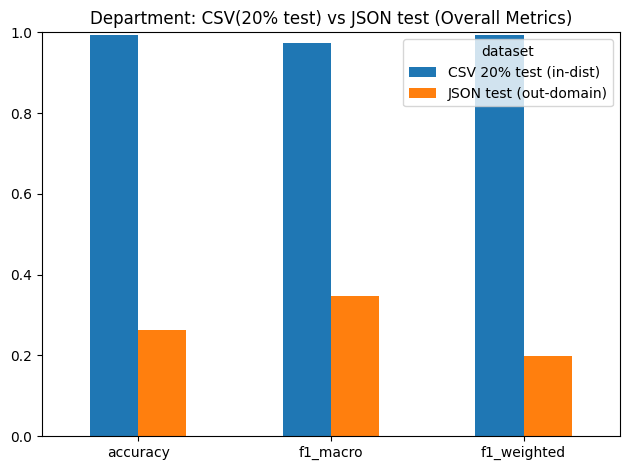

In [36]:
CSV_TEST_20 = build_metrics("CSV 20% test (in-dist)", true_labels, pred_labels)
JSON_TEST   = build_metrics("JSON test (out-domain)", true_labels_json, pred_labels_json)

metrics_df = pd.DataFrame([
    {"dataset": CSV_TEST_20["name"], "accuracy": CSV_TEST_20["accuracy"], "f1_macro": CSV_TEST_20["f1_macro"], "f1_weighted": CSV_TEST_20["f1_weighted"]},
    {"dataset": JSON_TEST["name"],   "accuracy": JSON_TEST["accuracy"],   "f1_macro": JSON_TEST["f1_macro"],   "f1_weighted": JSON_TEST["f1_weighted"]},
]).set_index("dataset")

display(metrics_df)

plt.figure()
metrics_df.T.plot(kind="bar")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.title("Department: CSV(20% test) vs JSON test (Overall Metrics)")
plt.tight_layout()
plt.show()

In [37]:
def per_class_f1(report_df):
    drop_rows = ["accuracy", "macro avg", "weighted avg"]
    cls = report_df.drop(index=[r for r in drop_rows if r in report_df.index], errors="ignore")
    cls = cls[cls.index.notnull()]
    return cls["f1-score"].astype(float)

f1_csv = per_class_f1(CSV_TEST_20["report_df"])
f1_json = per_class_f1(JSON_TEST["report_df"])

<Figure size 640x480 with 0 Axes>

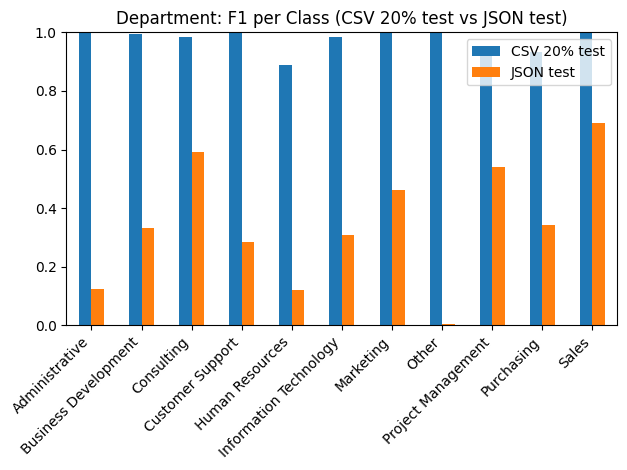

In [38]:
all_classes = sorted(set(f1_csv.index).union(set(f1_json.index)))
f1_compare = pd.DataFrame({
    "CSV 20% test": f1_csv.reindex(all_classes),
    "JSON test": f1_json.reindex(all_classes),
}).fillna(0)

plt.figure()
f1_compare.plot(kind="bar")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.title("Department: F1 per Class (CSV 20% test vs JSON test)")
plt.tight_layout()
plt.show()

# 4. Fine-tune with pseudo label

## a) Rule-based pseudo-labeling

In [39]:
department_list = [(row['text'], row['label']) for index, row in df_department.iterrows()]
seniority_list = [(row['text'], row['label']) for index, row in df_seniority.iterrows()]

df_pseudo_rule = df_pred_linkedin.copy()

X_pos = df_pseudo_rule["position"]

def pseudo_dept_rule(X_pos):
    for key, lab in department_list:
        if key in X_pos:
            return lab
    return "Other"

def pseudo_sen_rule(X_pos):
    for key, lab in seniority_list:
        if key in X_pos:
            return lab
    return "Other"

df_pseudo_rule["pseudo_dept_rule"] = X_pos.apply(pseudo_dept_rule)
df_pseudo_rule["pseudo_sen_rule"]  = X_pos.apply(pseudo_sen_rule)

df_pseudo_rule[["position", "pseudo_dept_rule", "pseudo_sen_rule"]].head(10)

,position,pseudo_dept_rule,pseudo_sen_rule
0,bookkeeper,Other,Other
1,co-owner,Other,Management
2,logistics officer,Other,Other
3,truck driver/ laborer,Other,Other
4,fuel driver,Other,Other
5,food delivery driver,Other,Other
6,regional driver,Other,Other
7,delivery/sales/mit,Information Technology,Other
8,strategy & investments,Other,Other
9,international event operations manager,Other,Senior


In [40]:
df_pseudo_rule["pseudo_dept_rule"].value_counts()

,count
pseudo_dept_rule,
Other,1188
Information Technology,327
Consulting,110
Sales,73
Marketing,57
Project Management,51
Business Development,36
Purchasing,20
Administrative,19


In [41]:
# retained only confidently labeled samples
df_pseudo_rule_conf = df_pseudo_rule[df_pseudo_rule["pseudo_dept_rule"] != "Other"]

# Pseudo-labeling was applied only to the Department
df_pseudo_rule_conf = df_pseudo_rule_conf[["position", "pseudo_dept_rule"]]

df_pseudo_rule_conf.head()

,position,pseudo_dept_rule
7,delivery/sales/mit,Information Technology
12,audit junior,Information Technology
13,pr & communication consultant,Consulting
21,corporate auditor,Information Technology
22,corporate auditor,Information Technology


In [42]:
# merge csv & pseudo labeled(json not-annotated)
df_gold = df_department[["text", "label"]].copy()

df_pseudo_rule_final = df_pseudo_rule_conf[["position", "pseudo_dept_rule"]].copy()
df_pseudo_rule_final.columns = ["text", "label"]

df_train_expanded = pd.concat([df_gold, df_pseudo_rule_final], ignore_index=True)

print("gold:", len(df_gold))
print("pseudo:", len(df_pseudo_rule_final))
print("expanded:", len(df_train_expanded))
print(df_train_expanded["label"].value_counts())
print(df_train_expanded.columns)


gold: 10145
pseudo: 698
expanded: 10843
label
Marketing                 4352
Sales                     3401
Information Technology    1632
Business Development       656
Consulting                 277
Project Management         252
Administrative             102
Purchasing                  60
Other                       42
Human Resources             36
Customer Support            33
Name: count, dtype: int64
Index(['text', 'label'], dtype='object')


In [43]:
from sklearn.model_selection import train_test_split

X_exp = df_train_expanded["text"]
y_exp = df_train_expanded["label"]

X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(
    X_exp, y_exp,
    test_size=0.2,
    random_state=42,
    )
print("Department train/test:", len(X_train_exp), len(X_test_exp))

Department train/test: 8674 2169


In [44]:
# labels -> ids (train-only)
labels_exp = pd.Index(pd.unique(y_train_exp)).sort_values()
label2id_exp = {lab: i for i, lab in enumerate(labels_exp)}
id2label_exp = {i: lab for lab, i in label2id_exp.items()}

y_train_exp_id = pd.Series(y_train_exp).map(label2id_exp)
y_test_exp_id  = pd.Series(y_test_exp).map(label2id_exp)

train_ds_exp = TextClsDataset(X_train_exp, y_train_exp_id, tokenizer)
test_ds_exp  = TextClsDataset(X_test_exp, y_test_exp_id, tokenizer)

print("Train dataset size:", len(train_ds_exp))
print("Test dataset size:", len(test_ds_exp))
print("Num classes:", len(labels_exp))


Train dataset size: 8674
Test dataset size: 2169
Num classes: 11


In [45]:
model_exp = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=len(labels_exp),
    id2label={i: lab for i, lab in enumerate(labels_exp)},
    label2id={lab: i for i, lab in enumerate(labels_exp)})

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
training_args = TrainingArguments(
    output_dir="./dep_distilbert_rule",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=6,
    weight_decay=0.05,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro"
)

In [47]:
trainer_exp = Trainer(
    model=model_exp,
    args=training_args,
    train_dataset=train_ds_exp,
    eval_dataset=test_ds_exp,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)

trainer_exp.train()
trainer_exp.evaluate()

/tmp/ipython-input-4205334938.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_exp = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.199800,0.169793,0.968649,0.751944,0.963838
2,0.096500,0.125134,0.976026,0.837989,0.973969
3,0.061400,0.112997,0.981558,0.916306,0.980961
4,0.046600,0.105307,0.984325,0.939751,0.984076
5,0.032400,0.108147,0.983864,0.939478,0.983581
6,0.018600,0.108016,0.984325,0.940413,0.984066


{'eval_loss': 0.10801570862531662,
 'eval_accuracy': 0.9843245735361917,
 'eval_f1_macro': 0.9404132877612184,
 'eval_f1_weighted': 0.9840660221605435,
 'eval_runtime': 7.1461,
 'eval_samples_per_second': 303.522,
 'eval_steps_per_second': 9.516,
 'epoch': 6.0}

In [48]:
# JUST A TEST
pred_logits = trainer_exp.predict(test_ds_exp).predictions
pred_ids = pred_logits.argmax(axis=1)

pred_labels_exp = pd.Series(pred_ids).map(id2label_exp)
pred_labels_exp.value_counts().head(20)

,count
Marketing,841
Sales,692
Information Technology,334
Business Development,126
Consulting,65
Project Management,50
Administrative,17
Purchasing,16
Customer Support,11
Other,11


In [49]:
true_labels_exp = y_test_exp_id.map(id2label_exp)
print(classification_report(true_labels_exp, pred_labels_exp, digits=4))

                        precision    recall  f1-score   support

        Administrative     0.8235    0.9333    0.8750        15
  Business Development     0.9921    0.9766    0.9843       128
            Consulting     0.9538    0.9841    0.9688        63
      Customer Support     1.0000    1.0000    1.0000        11
       Human Resources     1.0000    0.5455    0.7059        11
Information Technology     0.9611    0.9611    0.9611       334
             Marketing     0.9976    0.9941    0.9958       844
                 Other     1.0000    1.0000    1.0000        11
    Project Management     0.9000    0.9375    0.9184        48
            Purchasing     1.0000    0.8889    0.9412        18
                 Sales     0.9899    0.9985    0.9942       686

              accuracy                         0.9843      2169
             macro avg     0.9653    0.9291    0.9404      2169
          weighted avg     0.9846    0.9843    0.9841      2169



Json test

In [50]:
df_linkedin

,organization,linkedin,position,startDate,endDate,status,department,seniority
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
...,...,...,...,...,...,...,...,...
2632,malteserorden,,kanzler der deutschen assoziation,2015-01,None,active,Other,Management
2633,bistum,,justitiar,2014-03,None,active,Other,Professional
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management


In [51]:
exp_test = df_linkedin.copy()
exp_test = df_test[df_test["status"] == 'active'].copy()

X_json_exp = df_test["position"].fillna("").astype(str)
y_json_exp_raw = df_test["department"].fillna("").astype(str)

# unknown to Other
OTHER_LABEL = "Other"
if OTHER_LABEL not in label2id_exp:
    raise ValueError(f'"{OTHER_LABEL}" not in training label2id_exp. Check your training labels.')

y_json_exp = y_json_exp_raw.where(y_json_exp_raw.isin(label2id_exp.keys()), OTHER_LABEL)
y_json_exp_id = y_json_exp.map(label2id_exp)

In [52]:
(y_json_exp_raw != y_json_exp).value_counts()

,count
department,
False,623


In [53]:
json_test_ds_exp = TextClsDataset(X_json_exp, y_json_exp_id, tokenizer)

pred_logits_json_exp = trainer_exp.predict(json_test_ds_exp).predictions
pred_ids_json_exp = pred_logits_json_exp.argmax(axis=1)

pred_labels_json_exp = pd.Series(pred_ids_json_exp).map(id2label_exp)
true_labels_json_exp = y_json_exp_id.map(id2label_exp)

print(classification_report(true_labels_json_exp, pred_labels_json_exp, digits=4, zero_division=0))

json_out_metrics_exp = {
    "n_samples": len(exp_test),
    "n_unknown_mapped_to_other": int((y_json_exp_raw != y_json_exp).sum()),
    "accuracy": accuracy_score(true_labels_json_exp, pred_labels_json_exp),
    "f1_macro": f1_score(true_labels_json_exp, pred_labels_json_exp, average="macro"),
    "f1_weighted": f1_score(true_labels_json_exp, pred_labels_json_exp, average="weighted")}
json_out_metrics_exp


                        precision    recall  f1-score   support

        Administrative     0.2222    0.1429    0.1739        14
  Business Development     0.3750    0.3000    0.3333        20
            Consulting     0.7586    0.5641    0.6471        39
      Customer Support     1.0000    0.1667    0.2857         6
       Human Resources     0.3529    0.3750    0.3636        16
Information Technology     0.1250    0.9355    0.2205        62
             Marketing     0.6429    0.4091    0.5000        22
                 Other     0.0000    0.0000    0.0000       344
    Project Management     0.7857    0.5641    0.6567        39
            Purchasing     0.5455    0.4000    0.4615        15
                 Sales     0.8485    0.6087    0.7089        46

              accuracy                         0.2568       623
             macro avg     0.5142    0.4060    0.3956       623
          weighted avg     0.2433    0.2568    0.2114       623



{'n_samples': 623,
 'n_unknown_mapped_to_other': 0,
 'accuracy': 0.2568218298555377,
 'f1_macro': 0.39557307345689735,
 'f1_weighted': 0.21137211378178414}

In [54]:
def build_metrics(name, y_true, y_pred):
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    out = {
        "name": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "report_df": pd.DataFrame(
            classification_report(y_true, y_pred, digits=4, output_dict=True, zero_division=0)
        ).T}
    return out

,accuracy,f1_macro,f1_weighted
dataset,,,
CSV 20% test (in-dist),0.984325,0.940413,0.984066
JSON test (out-domain),0.256822,0.395573,0.211372


<Figure size 640x480 with 0 Axes>

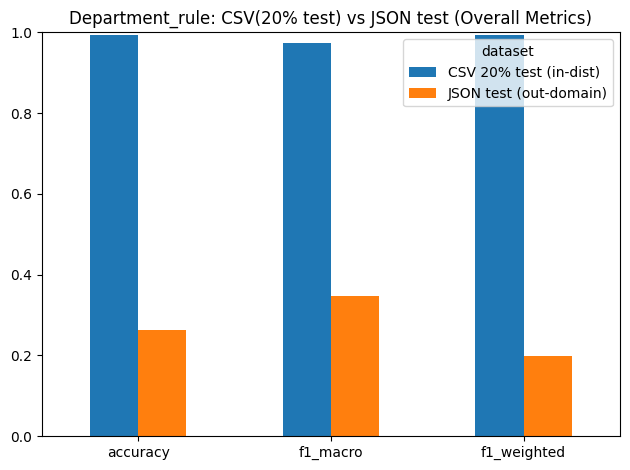

In [55]:
CSV_TEST_20_exp = build_metrics("CSV 20% test (in-dist)", true_labels_exp, pred_labels_exp)
JSON_TEST_exp  = build_metrics("JSON test (out-domain)", true_labels_json_exp, pred_labels_json_exp)

metrics_df_exp = pd.DataFrame([
    {"dataset": CSV_TEST_20_exp["name"], "accuracy": CSV_TEST_20_exp["accuracy"], "f1_macro": CSV_TEST_20_exp["f1_macro"], "f1_weighted": CSV_TEST_20_exp["f1_weighted"]},
    {"dataset": JSON_TEST_exp["name"],   "accuracy": JSON_TEST_exp["accuracy"],   "f1_macro": JSON_TEST_exp["f1_macro"],   "f1_weighted": JSON_TEST_exp["f1_weighted"]},
]).set_index("dataset")

display(metrics_df_exp)

plt.figure()
metrics_df.T.plot(kind="bar")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.title("Department_rule: CSV(20% test) vs JSON test (Overall Metrics)")
plt.tight_layout()
plt.show()

In [56]:
def per_class_f1(report_df):
    drop_rows = ["accuracy", "macro avg", "weighted avg"]
    cls = report_df.drop(index=[r for r in drop_rows if r in report_df.index], errors="ignore")
    cls = cls[cls.index.notnull()]
    return cls["f1-score"].astype(float)

f1_csv_exp = per_class_f1(CSV_TEST_20_exp["report_df"])
f1_json_exp = per_class_f1(JSON_TEST_exp["report_df"])

<Figure size 640x480 with 0 Axes>

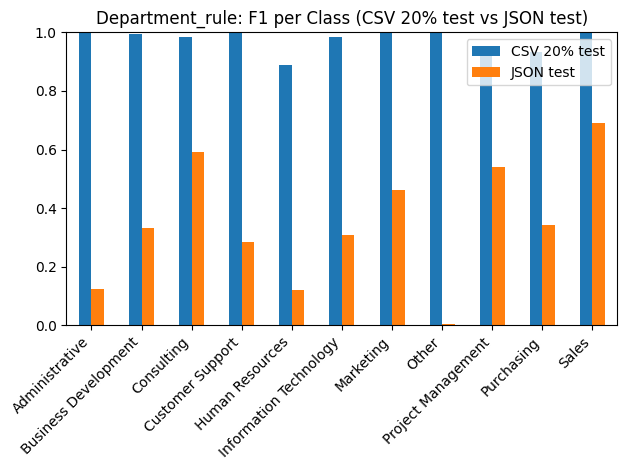

In [57]:
all_classes_exp = sorted(set(f1_csv_exp.index).union(set(f1_json_exp.index)))
f1_compare_exp = pd.DataFrame({
    "CSV 20% test": f1_csv_exp.reindex(all_classes),
    "JSON test": f1_json_exp.reindex(all_classes),
}).fillna(0)

plt.figure()
f1_compare.plot(kind="bar")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.title("Department_rule: F1 per Class (CSV 20% test vs JSON test)")
plt.tight_layout()
plt.show()

## b) Embedding-based labelling

In [58]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [59]:
df_pseudo_em = df_pred_linkedin.copy()

# Get labels from csv
dept_labels = sorted(df_department["label"].unique().tolist())

dept_embedding = model.encode(dept_lables, convert_to_tensor=True)

# encode all positions
X_em = df_pseudo_em['position']
position_embedding = model.encode(X_em, convert_to_tensor=True)

# cosine similarity matrix: (N, C)
scores = util.cos_sim(position_embedding, dept_embedding)

# top1 label + top1 score
top1_scores, top1_idx = torch.max(scores, dim=1)
pred_dept_em = [dept_labels[i] for i in top1_idx.cpu().numpy()]

df_pseudo_em["pseudo_dept_emb_raw"] = pred_dept_em
df_pseudo_em["emb_score_top1"] = top1_scores.cpu().numpy()



In [60]:
df_pseudo_em["emb_score_top1"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])


,emb_score_top1
count,1886.000000
mean,0.414642
std,0.153709
min,0.067898
50%,0.402344
75%,0.499266
90%,0.630972
95%,0.693250
99%,0.864035
max,1.000000


In [61]:
df_pseudo_em["pseudo_dept_emb_raw"].value_counts().head(10)

,count
pseudo_dept_emb_raw,
Consulting,638
Human Resources,273
Business Development,213
Customer Support,168
Information Technology,121
Marketing,106
Administrative,103
Purchasing,100
Sales,87


In [62]:
thr = df_pseudo_em["emb_score_top1"].quantile(0.90)

df_pseudo_em_conf = df_pseudo_em[
    df_pseudo_em["emb_score_top1"] >= thr
].copy()

len(df_pseudo_em_conf)

189

In [63]:
display(df_pseudo_em_conf["pseudo_dept_emb_raw"].value_counts())

,count
pseudo_dept_emb_raw,
Human Resources,77
Business Development,39
Purchasing,19
Information Technology,13
Administrative,13
Customer Support,10
Sales,8
Consulting,8
Project Management,1


In [64]:
# merge csv & pseudo labeled(json not-annotated)
df_gold = df_department[["text", "label"]].copy()
df_pseudo_em_final = df_pseudo_em_conf[['position', 'pseudo_dept_emb_raw']].copy()
df_pseudo_em_final.columns = ['text', 'label']

df_pseudo_rule_final.columns = ["text", "label"]

df_train_expanded_em = pd.concat([df_gold, df_pseudo_em_final], ignore_index=True)

print("gold:", len(df_gold))
print("pseudo:", len(df_pseudo_em_final))
print("expanded:", len(df_train_expanded_em))
print(df_train_expanded_em["label"].value_counts())
print(df_train_expanded_em.columns)


gold: 10145
pseudo: 189
expanded: 10334
label
Marketing                 4296
Sales                     3336
Information Technology    1318
Business Development       659
Project Management         202
Consulting                 175
Human Resources            108
Administrative              96
Purchasing                  59
Customer Support            43
Other                       42
Name: count, dtype: int64
Index(['text', 'label'], dtype='object')


In [65]:
from sklearn.model_selection import train_test_split

X_expem = df_train_expanded["text"]
y_expem = df_train_expanded["label"]

X_train_expem, X_test_expem, y_train_expem, y_test_expem = train_test_split(
    X_expem, y_expem,
    test_size=0.2,
    random_state=42,
    )
print("Department train/test:", len(X_train_expem), len(X_test_expem))

Department train/test: 8674 2169


In [66]:
from sklearn.model_selection import train_test_split

X_expem = df_train_expanded_em["text"]
y_expem = df_train_expanded_em["label"]

X_train_expem, X_test_expem, y_train_expem, y_test_expem = train_test_split(
    X_expem, y_expem,
    test_size=0.2,
    random_state=42,
    )

y_train_expem_id = pd.Series(y_train_expem).map(label2id_dep)
y_test_expem_id  = pd.Series(y_test_expem).map(label2id_dep)

In [67]:
# labels -> ids (train-only)
labels_expem = pd.Index(pd.unique(y_train_expem)).sort_values()
label2id_expem = {lab: i for i, lab in enumerate(labels_expem)}
id2label_expem = {i: lab for lab, i in label2id_expem.items()}

y_train_expem_id = pd.Series(y_train_expem).map(label2id_expem)
y_test_expem_id  = pd.Series(y_test_expem).map(label2id_expem)

train_ds_expem = TextClsDataset(X_train_expem, y_train_expem_id, tokenizer)
test_ds_expem  = TextClsDataset(X_test_expem, y_test_expem_id, tokenizer)

print("Train dataset size:", len(train_ds_expem))
print("Test dataset size:", len(test_ds_expem))
print("Num classes:", len(labels_expem))


Train dataset size: 8267
Test dataset size: 2067
Num classes: 11


In [68]:
train_ds_expem = TextClsDataset(X_train_expem, y_train_expem_id, tokenizer)
test_ds_expem  = TextClsDataset(X_test_expem,  y_test_expem_id,  tokenizer)

print("Train dataset size:", len(train_ds_expem))
print("Test dataset size:", len(test_ds_expem))

Train dataset size: 8267
Test dataset size: 2067


In [69]:
model_expem = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=len(labels_expem),
    id2label={i: lab for i, lab in enumerate(labels_expem)},
    label2id={lab: i for i, lab in enumerate(labels_expem)})

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
training_args = TrainingArguments(
    output_dir="./dep_distilbert_emb",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=6,
    weight_decay=0.05,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro"
  )

In [72]:
trainer_expem = Trainer(
    model=model_expem,
    args=training_args,
    train_dataset=train_ds_expem,
    eval_dataset=test_ds_expem,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)

trainer_expem.train()
trainer_expem.evaluate()

/tmp/ipython-input-907491520.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_expem = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.183700,0.141194,0.961297,0.629808,0.954332
2,0.108900,0.097687,0.977262,0.844660,0.975603
3,0.087000,0.096958,0.979681,0.909936,0.979191
4,0.085500,0.081334,0.984035,0.929098,0.984015
5,0.044200,0.092080,0.981132,0.926632,0.980821
6,0.068000,0.084476,0.981616,0.921737,0.981532


{'eval_loss': 0.0813339501619339,
 'eval_accuracy': 0.9840348330914369,
 'eval_f1_macro': 0.9290984272185312,
 'eval_f1_weighted': 0.9840149067378068,
 'eval_runtime': 6.9423,
 'eval_samples_per_second': 297.74,
 'eval_steps_per_second': 9.363,
 'epoch': 6.0}

In [73]:
# JUST A TEST
pred_logits = trainer_exp.predict(test_ds_expem).predictions
pred_ids = pred_logits.argmax(axis=1)

pred_labels_expem = pd.Series(pred_ids).map(id2label_expem)
pred_labels_expem.value_counts().head(20)

,count
Marketing,868
Sales,671
Information Technology,268
Business Development,122
Project Management,49
Consulting,47
Customer Support,10
Administrative,10
Human Resources,8
Other,7


In [74]:
true_labels_expem = y_test_expem_id.map(id2label_expem)
print(classification_report(true_labels_expem, pred_labels_expem, digits=4))

                        precision    recall  f1-score   support

        Administrative     1.0000    0.8333    0.9091        12
  Business Development     0.9918    0.9453    0.9680       128
            Consulting     0.5745    1.0000    0.7297        27
      Customer Support     1.0000    0.9091    0.9524        11
       Human Resources     0.7500    0.2400    0.3636        25
Information Technology     0.9739    0.9812    0.9775       266
             Marketing     0.9954    0.9954    0.9954       868
                 Other     1.0000    1.0000    1.0000         7
    Project Management     0.8776    0.9773    0.9247        44
            Purchasing     1.0000    0.7000    0.8235        10
                 Sales     0.9955    0.9985    0.9970       669

              accuracy                         0.9792      2067
             macro avg     0.9235    0.8709    0.8765      2067
          weighted avg     0.9816    0.9792    0.9778      2067



Json test

In [75]:
df_linkedin

,organization,linkedin,position,startDate,endDate,status,department,seniority
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
...,...,...,...,...,...,...,...,...
2632,malteserorden,,kanzler der deutschen assoziation,2015-01,None,active,Other,Management
2633,bistum,,justitiar,2014-03,None,active,Other,Professional
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management


In [77]:
expem_test = df_linkedin.copy()
expem_test = expem_test[expem_test["status"] == 'active'].copy()

X_json_expem = expem_test["position"].fillna("").astype(str)
y_json_expem_raw = expem_test["department"].fillna("").astype(str)

# unknown to Other
OTHER_LABEL = "Other"
if OTHER_LABEL not in label2id_expem:
    raise ValueError(f'"{OTHER_LABEL}" not in training label2id_exp. Check your training labels.')

y_json_expem = y_json_expem_raw.where(y_json_expem_raw.isin(label2id_expem.keys()), OTHER_LABEL)
y_json_expem_id = y_json_expem.map(label2id_expem)

In [78]:
(y_json_expem_raw != y_json_expem).value_counts()

,count
department,
False,623


In [79]:
json_test_ds_expem = TextClsDataset(X_json_expem, y_json_expem_id, tokenizer)

pred_logits_json_expem = trainer_expem.predict(json_test_ds_expem).predictions
pred_ids_json_expem = pred_logits_json_expem.argmax(axis=1)

pred_labels_json_expem = pd.Series(pred_ids_json_expem).map(id2label_expem)
true_labels_json_expem = y_json_expem_id.map(id2label_expem)

print(classification_report(true_labels_json_expem, pred_labels_json_expem, digits=4, zero_division=0))

json_out_metrics_expem = {
    "n_samples": len(expem_test),
    "n_unknown_mapped_to_other": int((y_json_expem_raw != y_json_expem).sum()),
    "accuracy": accuracy_score(true_labels_json_expem, pred_labels_json_expem),
    "f1_macro": f1_score(true_labels_json_expem, pred_labels_json_expem, average="macro"),
    "f1_weighted": f1_score(true_labels_json_expem, pred_labels_json_expem, average="weighted")}
json_out_metrics_expem

                        precision    recall  f1-score   support

        Administrative     0.0172    0.0714    0.0278        14
  Business Development     0.3000    0.3000    0.3000        20
            Consulting     0.2911    0.5897    0.3898        39
      Customer Support     0.1250    0.1667    0.1429         6
       Human Resources     0.2333    0.4375    0.3043        16
Information Technology     0.1793    0.7258    0.2875        62
             Marketing     0.4286    0.4091    0.4186        22
                 Other     0.7500    0.0087    0.0172       344
    Project Management     0.5490    0.7179    0.6222        39
            Purchasing     0.1739    0.5333    0.2623        15
                 Sales     0.5636    0.6739    0.6139        46

              accuracy                         0.2600       623
             macro avg     0.3283    0.4213    0.3079       623
          weighted avg     0.5627    0.2600    0.1874       623



{'n_samples': 623,
 'n_unknown_mapped_to_other': 0,
 'accuracy': 0.26003210272873195,
 'f1_macro': 0.3078707192818068,
 'f1_weighted': 0.18736037929239371}

In [80]:
def build_metrics(name, y_true, y_pred):
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    out = {
        "name": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "report_df": pd.DataFrame(
            classification_report(y_true, y_pred, digits=4, output_dict=True, zero_division=0)
        ).T}
    return out

,accuracy,f1_macro,f1_weighted
dataset,,,
CSV 20% test (in-dist),0.979197,0.876458,0.977761
JSON test (out-domain),0.260032,0.307871,0.187360


<Figure size 640x480 with 0 Axes>

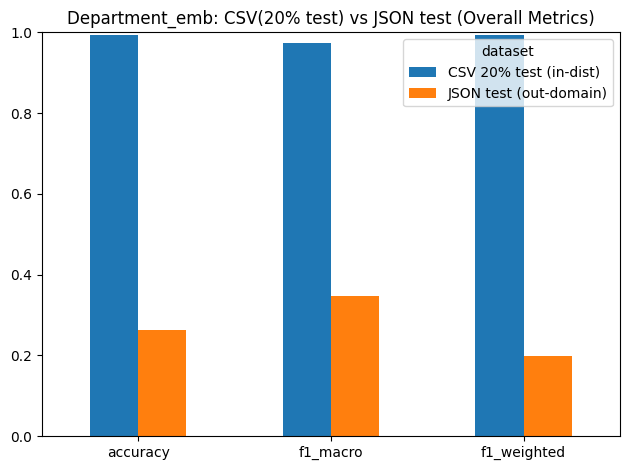

In [81]:
CSV_TEST_20_expem = build_metrics("CSV 20% test (in-dist)", true_labels_expem, pred_labels_expem)
JSON_TEST_expem  = build_metrics("JSON test (out-domain)", true_labels_json_expem, pred_labels_json_expem)

metrics_df_expem = pd.DataFrame([
    {"dataset": CSV_TEST_20_expem["name"], "accuracy": CSV_TEST_20_expem["accuracy"], "f1_macro": CSV_TEST_20_expem["f1_macro"], "f1_weighted": CSV_TEST_20_expem["f1_weighted"]},
    {"dataset": JSON_TEST_expem["name"],   "accuracy": JSON_TEST_expem["accuracy"],   "f1_macro": JSON_TEST_expem["f1_macro"],   "f1_weighted": JSON_TEST_expem["f1_weighted"]},
]).set_index("dataset")

display(metrics_df_expem)

plt.figure()
metrics_df.T.plot(kind="bar")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.title("Department_emb: CSV(20% test) vs JSON test (Overall Metrics)")
plt.tight_layout()
plt.show()

In [82]:
def per_class_f1(report_df):
    drop_rows = ["accuracy", "macro avg", "weighted avg"]
    cls = report_df.drop(index=[r for r in drop_rows if r in report_df.index], errors="ignore")
    cls = cls[cls.index.notnull()]
    return cls["f1-score"].astype(float)

f1_csv_expem = per_class_f1(CSV_TEST_20_expem["report_df"])
f1_json_expem = per_class_f1(JSON_TEST_expem["report_df"])

<Figure size 640x480 with 0 Axes>

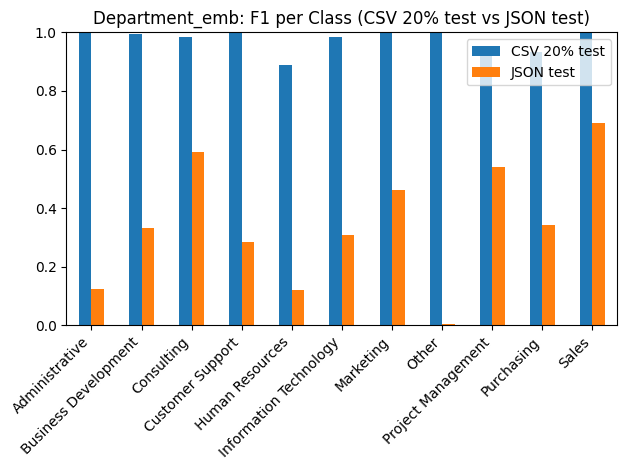

In [83]:
all_classes_expem = sorted(set(f1_csv_expem.index).union(set(f1_json_expem.index)))
f1_compare_expem = pd.DataFrame({
    "CSV 20% test": f1_csv_expem.reindex(all_classes),
    "JSON test": f1_json_expem.reindex(all_classes),
}).fillna(0)

plt.figure()
f1_compare.plot(kind="bar")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.title("Department_emb: F1 per Class (CSV 20% test vs JSON test)")
plt.tight_layout()
plt.show()

Performance comparsion

In [84]:
JSON_TEST = build_metrics("JSON test (out-domain)", true_labels_json, pred_labels_json)
JSON_TEST_exp  = build_metrics("JSON test (out-domain)", true_labels_json_exp, pred_labels_json_exp)
JSON_TEST_expem  = build_metrics("JSON test (out-domain)", true_labels_json_expem, pred_labels_json_expem)


,accuracy,macro avg,weighted avg
Model Type,,,
Initial,0.261637,0.345881,0.199603
Rule-pseudo,0.256822,0.395573,0.211372
Emb-pseudo,0.260032,0.307871,0.187360


<Figure size 640x480 with 0 Axes>

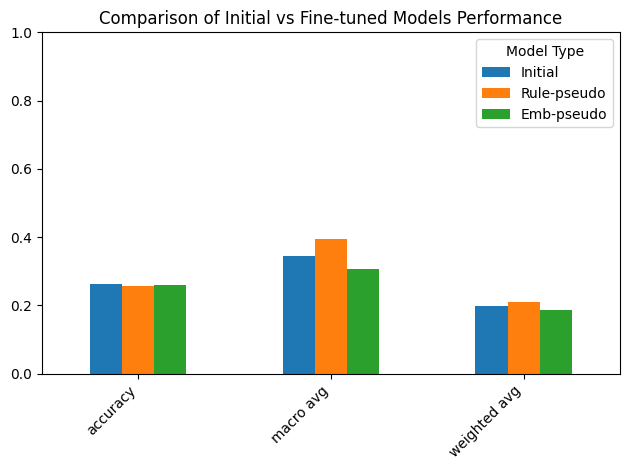

In [85]:
overall_df = pd.DataFrame([
    {"Model Type": "Initial",     "accuracy": JSON_TEST["accuracy"],     "macro avg": JSON_TEST["f1_macro"],     "weighted avg": JSON_TEST["f1_weighted"]},
    {"Model Type": "Rule-pseudo", "accuracy": JSON_TEST_exp["accuracy"], "macro avg": JSON_TEST_exp["f1_macro"], "weighted avg": JSON_TEST_exp["f1_weighted"]},
    {"Model Type": "Emb-pseudo",  "accuracy": JSON_TEST_expem["accuracy"],"macro avg": JSON_TEST_expem["f1_macro"],"weighted avg": JSON_TEST_expem["f1_weighted"]},
]).set_index("Model Type")

display(overall_df)

plt.figure()
overall_df.T.plot(kind="bar")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.title("Comparison of Initial vs Fine-tuned Models Performance")
plt.tight_layout()
plt.show()

,Initial,Rule-pseudo,Emb-pseudo
Administrative,0.125000,0.173913,0.027778
Business Development,0.333333,0.333333,0.300000
Consulting,0.591549,0.647059,0.389831
Customer Support,0.285714,0.285714,0.142857
Human Resources,0.120000,0.363636,0.304348
Information Technology,0.308725,0.220532,0.287540
Marketing,0.461538,0.500000,0.418605
Other,0.005780,0.000000,0.017241
Project Management,0.540541,0.656716,0.622222
Purchasing,0.342857,0.461538,0.262295


<Figure size 1200x500 with 0 Axes>

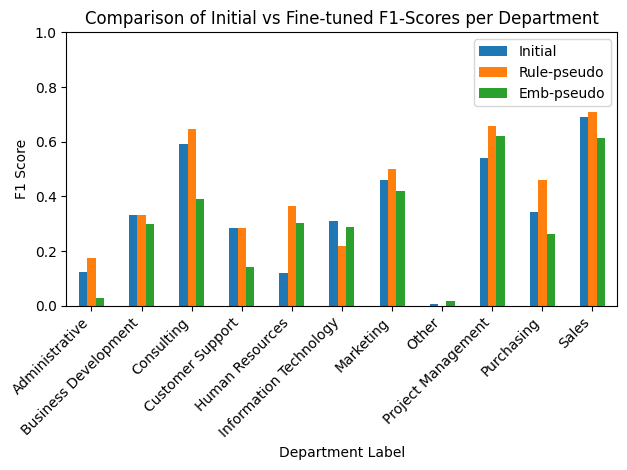

In [86]:
def per_class_f1(report_df):
    drop_rows = ["accuracy", "macro avg", "weighted avg"]
    cls = report_df.drop(index=[r for r in drop_rows if r in report_df.index], errors="ignore")
    cls = cls[cls.index.notnull()]
    return cls["f1-score"].astype(float)

# per-class f1 of models
f1_json = per_class_f1(JSON_TEST["report_df"])
f1_json_exp = per_class_f1(JSON_TEST_exp["report_df"])
f1_json_expem = per_class_f1(JSON_TEST_expem["report_df"])

# class
all_classes = sorted(set(f1_json.index) | set(f1_json_exp.index) | set(f1_json_expem.index))

f1_compare_all = pd.DataFrame({
    "Initial": f1_json.reindex(all_classes),
    "Rule-pseudo": f1_json_exp.reindex(all_classes),
    "Emb-pseudo": f1_json_expem.reindex(all_classes),
}).fillna(0)

display(f1_compare_all)

# plot
plt.figure(figsize=(12, 5))
f1_compare_all.plot(kind="bar")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.title("Comparison of Initial vs Fine-tuned F1-Scores per Department")
plt.xlabel("Department Label")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()
